## Predicting Price with Size

In [1]:
# !pip install scikit-learn

In [2]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

warnings.simplefilter(action="ignore", category=FutureWarning)

Creating a model to predict apartment prices in the city of Tango, with a particular emphasis on apartments priced below $400,000 USD.

# Prepare Data

## Import

In [3]:
def wrangle(filepath):
    """
    Reads data from the specified file path and returns a DataFrame.

    Parameters:
    - file_path : The path to the file containing the data.

    Returns:
    - DataFrame: A DataFrame containing the loaded data.
    """
    df = pd.read_csv(filepath, encoding='ISO-8859-1')
    
    # Subset to place `"Capital Federal"`
    mask_place = df["place_with_parent_names"].str.contains("Capital Federal")
    
    # Subset to `"apartment"`
    mask_apar = df["property_type"] == 'apartment'
    
    # Subset to `"price_approx_usd"`
    mask_price = df["price_aprox_usd"] < 400_000
    
    df = df[mask_place & mask_apar & mask_price]
    
    # Remove outliers by `"surface_covered_in_m2"`
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]
    
    return df

In [4]:
# Use the wrangle function to create df 
df = wrangle("data/tango-real-estate-1.csv")
print("df shape:", df.shape)
df.head()

df shape: (1343, 16)


,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
4,sell,apartment,|Argentina|Capital Federal|Chacarita|,"-34.5846508988,-58.4546932614",129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...
9,sell,apartment,|Argentina|Capital Federal|Villa Luro|,"-34.6389789,-58.500115",87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...
29,sell,apartment,|Argentina|Capital Federal|Caballito|,"-34.615847,-58.459957",118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...
40,sell,apartment,|Argentina|Capital Federal|Constitución|,"-34.6252219,-58.3823825",57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364.0,http://constitucion.properati.com.ar/k2f0_vent...
41,sell,apartment,|Argentina|Capital Federal|Once|,"-34.6106102,-58.4125107",90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450.0,http://once.properati.com.ar/suwa_venta_depart...


## Explore

Text(0.5, 1.0, 'Distribution of Apartment Sizes')

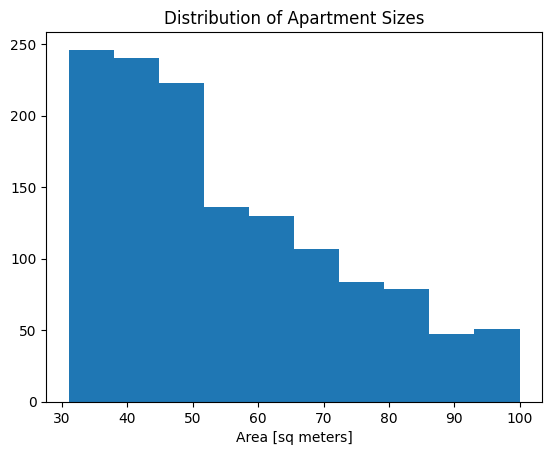

In [5]:
# Plot the distribution of apartment sizes
plt.hist(df["surface_covered_in_m2"])
plt.xlabel("Area [sq meters]")
plt.title("Distribution of Apartment Sizes")

In [6]:
# Summary statistics for df
df.describe()['surface_covered_in_m2']

count    1343.000000
mean       55.076694
std        18.160427
min        31.000000
25%        40.000000
50%        50.000000
75%        68.500000
max       100.000000
Name: surface_covered_in_m2, dtype: float64

Text(0, 0.5, 'Price [USD]')

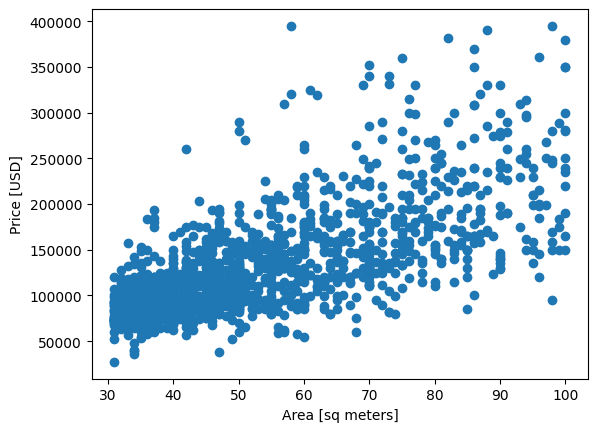

In [7]:
# Plot price vs area
plt.scatter(df["surface_covered_in_m2"], df["price_aprox_usd"])
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")

This plot suggests that there's a moderate positive correlation between apartment price and size. This means that if  thing we want to predict is price, size will be a good feature to include. 

## Split

In [13]:
# Create feature matrix: X_train using "surface_covered_in_m2" (2D)
features = ["surface_covered_in_m2"]
X_train = df[features]
X_train.shape

(1343, 1)

In [14]:
# Create target vector: y_train using "price_aprox_usd" (1D)
target = "price_aprox_usd"
y_train = df[target]
y_train.shape

(1343,)

# Build Model

## Baseline

How well is the built model performing? Also known as naive model, but it's always a model makes only one prediction — in this case, it predicts the same price regardless of an apartment's size.

In [15]:
# Calculate the mean of the target vector `y_train`
y_mean = y_train.mean()
y_mean

135527.83871928515

In [16]:
# Create a list containing repeated values of `y_mean`
y_pred_baseline = [y_mean] * len(y_train)
len(y_pred_baseline) == len(y_train)

True

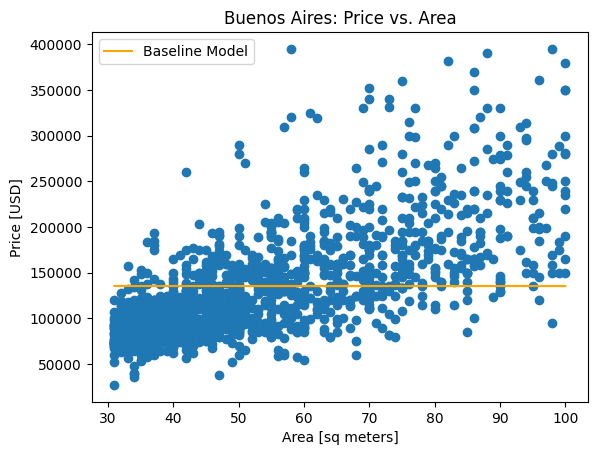

In [19]:
# Line plot to show the relationship between the observations `X_train` and our dumb model's predictions `y_pred_baseline`.
plt.plot(X_train["surface_covered_in_m2"], y_pred_baseline, color="orange", label="Baseline Model")
plt.scatter(X_train, y_train)
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Buenos Aires: Price vs. Area")
plt.legend();

This visualization, it seems like the baseline model doesn't really follow the trend in the data. Use of performance metric: mean absulote error.